# 🚀 Motion Classifier Tutorial: Data Labeling with Snorkel

In this tutorial, we will walk through the process of using Snorkel to build a training set for classifying court docket entries as MOTION or NOT MOTION.

Resources:
* For an overview of Snorkel, visit [snorkel.org](https://snorkel.org)
* You can also check out the [Snorkel API documentation](https://snorkel.readthedocs.io/)
* For some real-world applications, check out [Snorkel Applications](https://www.snorkel.org/resources/)
* Why does this work? See [Data Programming: Creating Large Training Sets, Quickly](https://arxiv.org/abs/1605.07723)
* Snorkel paper: [Snorkel: Rapid Training Data Creation with Weak Supervision](https://arxiv.org/abs/1711.10160)

The goal of this tutorial is to illustrate some basic components and concepts of Snorkel in a simple way, but also to dive into a process of iteratively developing a text classifier in Snorkel.

**The goal of this research is to design an interaction for a non-technical, domain expert to quickly label a dataset.**

To achieve this goal, we start with a basic task: *binary text classification* of court docket entries as MOTION or NOT MOTION.

We have access to a large amount of *unlabeled data* (about 1 300 000 samples) in the form of court docket entries with some metadata. We also have access to about *7000 labeled samples*.

In order to train a classifier, we need to label our data, but doing so by hand for real world applications can often be prohibitively slow and expensive.

In these cases, we can turn to a _weak supervision_ approach, using **_labeling functions (LFs)_** in Snorkel: noisy, programmatic rules and heuristics that assign labels to unlabeled training data.

We'll dive into the Snorkel API and how we write labeling functions later in this tutorial, but as an example, we can write an LF that labels data points with `"MOTION to"` in the docket entry text as MOTION since many motions contain `"MOTION to"`:

```python
from snorkel.labeling import labeling_function

@labeling_function()
def lf_contains_motion_to(x):
    # Return a label of MOTION if "MOTION to" in document text, otherwise ABSTAIN
    return MOTION if "motion to" in x.text.lower() else ABSTAIN
```

The tutorial is divided into four parts:
1. **Loading Data**: We load a US courts docket entries dataset, originally used in ["From data to information: automating data science to explore the U.S. court system"](https://dl.acm.org/doi/abs/10.1145/3462757.3466100).

2. **Writing Labeling Functions**: We write Python programs that take as input a data point and assign labels (or abstain) using heuristics, pattern matching, and third-party models.

3. **Combining Labeling Function Outputs with the Label Model**: We model the outputs of the labeling functions over the training set using a Snorkel's, theoretically-grounded modeling approach, ["Data Programming:
Creating Large Training Sets, Quickly"](https://arxiv.org/abs/1605.07723), which estimates the accuracies and correlations of the labeling functions using only their agreements and disagreements, and then uses this to reweight and combine their outputs, which we then use as _probabilistic_ training labels.

4. **Training a Classifier**: We train a classifier that can predict labels for *any* court docket entry (not just the ones labeled by the labeling functions) using the probabilistic training labels from step 3.

In future work, we'll consider *multiclass text classification* of court docket entries as MOTION type. Multiclass text classication is an important problem to work on because we need to define a process that is robust to *concept drift*. The set of classes could expand or change over time, and we do not want to start the labeling process from scratch.

**Note that this process requires programming, but out target user is not technical.**

# The code starts here

## Imports

In [1]:
import re
import numpy as np
import pandas as pd

import metal
import snorkel
from snorkel.labeling import labeling_function, filter_unlabeled_dataframe, LabelingFunction, PandasLFApplier, LFAnalysis
from snorkel.labeling.model.label_model import LabelModel
from snorkel.labeling.model.baselines import MajorityClassVoter
from snorkel.labeling.model.baselines import MajorityLabelVoter
from snorkel.utils import probs_to_preds

import spacy
from spacy import displacy
from spacy.lang.en import English

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

Set `DISPLAY_FULL_TEXT` to `True` if you want to see the full docket entry texts.

In [2]:
DISPLAY_FULL_TEXT = True
pd.set_option('display.max_colwidth', 0 if DISPLAY_FULL_TEXT else 50)

## 1. Loading Data

In [3]:
data_dir = 'datasets/court_docket_entries'

We have 5 files:
1. `motionEntries.csv`: 1 300 000 docket entries, almost all unlabeled, with `text` and `id`
2. `tags.csv`: a mapping from `tag_id` to `label`, which is `motion class`
3. `thingy.csv`: looks like we can ignore this
4. `users.csv`: the annotators
5. `usertags`: 7 000 annotations for the docket entries with `docket_entry_id` and `tag_id`

In [4]:
# thingy = pd.read_csv(f"{data_dir}/thingy.csv")
# users = pd.read_csv(f"{data_dir}/users.csv")

We load the data from `motionEntries.csv`, `tags.csv`, and `usertags.csv`, rename some columns, and merge the data into one dataframe.

In [5]:
entries = pd.read_csv(f"{data_dir}/motionEntries.csv")
entries_columns = ['id', 'text', 'case_id', 'sealed', 'jurisdiction']
entries = entries[entries_columns].rename(columns={"id": "docket_entry_id"})

In [6]:
print(f"We have {entries.shape[0]} docket entries")

We have 1377516 docket entries


In [7]:
tags = pd.read_csv(f"{data_dir}/tags.csv")
# tags_columns = ['id', 'label', 'count']
tags_columns = ['id', 'label']
tags = tags[tags_columns].rename(columns={'id': 'tag_id'})
tags['motion'] = tags['tag_id'].apply(lambda x: int(x not in [26, 28]))

In [8]:
usertags = pd.read_csv(f"{data_dir}/usertags.csv")
usertags_columns = ['id', 'docket_entry_id', 'tag_id']
usertags = usertags[usertags_columns].rename(columns={'id': 'usertags_id'})

In [9]:
print(f"We have {usertags.shape[0]} labeled docket entries")

We have 7990 labeled docket entries


We merge the dataframes to get the text and motion label for each docket entry. Also, we remove the samples with label 'SKIP' because we don't know what to do with them.

In [10]:
labels = pd.merge(usertags, tags, on='tag_id')
labeled_motions = pd.merge(labels, entries, on='docket_entry_id')
labeled_motions = labeled_motions[labeled_motions['label'] != 'SKIP']
print(f"We have {labeled_motions.shape[0]} labeled docket entries when we remove SKIP.")

We have 6610 labeled docket entries when we remove SKIP.


Let's now create our dataset of labeled functions. We have 6610 samples if we remove the docket entries with label 'SKIP'.

In [11]:
keep_columns = ['docket_entry_id', 'motion', 'text']
lf_set = labeled_motions[keep_columns]

In [12]:
lf_set.head()

,docket_entry_id,motion,text
1,3112,1,"MOTION (Oral) by USA for excludable time from 9/18/07 through and including 10/04/07 pursuant to 18 USC 3161(h)(1) & (h)((1)(F) as to Demario Flemming (jmm-r, ) (Entered: 09/20/2007)"
4,9574,0,"DECLARATION of Aref Abdellatif regarding order on motion to compel,,,,,,, text entry,,,,,, 186 (Schaller, Rachel) (Entered: 08/19/2019)"
5,9574,0,"DECLARATION of Aref Abdellatif regarding order on motion to compel,,,,,,, text entry,,,,,, 186 (Schaller, Rachel) (Entered: 08/19/2019)"
9,4068,1,"MOTION by Tori Frederick DEFENDANT'S MOTION FOR PRETRIAL RELEASE (Rodriguez, Sergio) (Entered: 02/15/2008)"
11,833,1,"(Unopposed) NOTICE of Motion by Kathryn Ann Kelly for presentment of motion for leave to file excess pages 44 before Honorable M. David Weisman on 10/26/2017 at 09:15 AM. (Kelly, Kathryn) (Entered: 10/23/2017)"


Create train, dev, test split: 60/20/20.

In [13]:
# SPLIT_1 = 0.4
SPLIT_1 = 0.4
# SPLIT_2 = 0.5

In [14]:
df_train, df_test = train_test_split(lf_set, stratify=lf_set['motion'], test_size=SPLIT_1)
df_val, df_test = train_test_split(df_test, stratify=df_test['motion'], test_size=0.5)

In [15]:
def get_n_samples(df, n):
    return df.sample(n)

Let's set out voting values. Recall that the classification task is MOTION or NOT MOTION.

## 2. Making Labeling Functions

### Defining the classes

In [16]:
# Set voting values.
ABSTAIN = -1 
MOTION = 1 
NOT_MOTION = 0

### Data exploration

Let's look at 10 samples labeled as `MOTION`

In [17]:
get_n_samples(df_train, 10)

,docket_entry_id,motion,text
4702,11599,0,CASE DISMISSED with prejudice pursuant to 16 Stipulated Motion to Dismiss. (mc) (Entered: 03/07/2018)
4096,12499,0,"DETENTION/ARRAIGNMENT HEARING as to Jamie Buckner re Counts 1-8 of Indictment held on 6/27/2016 in US District Court - Fort Wayne. Hearing held via video conferencing before Magistrate Judge Andrew P Rodovich in US District Court - Hammond. Govt appeared by atty Stacey Speith, and Steven Sadowitz, Postal Inspector. Dft appeared with atty Thomas Allen. Matthew Koon appeared on behalf of U S Probation/Pretrial Services. Dft waives and gives up her right to a Detention Hearing. Court orders Dft detained pending further proceedings. Dft enters plea of not guilty to Counts 1-8 of Indictment (Arraignment Order attached). Pretrial motions due by 7/25/2016. Telephonic Final Pretrial Conference and 3-day Jury Trial to be set by Presiding Judge by separate Order. Dft remanded to custody of USM. (FTR 1st floor.) (mr) (Entered: 06/28/2016)"
1001,16379,1,"MOTION for More Time to File 30 Petition for Writ of Habeas Corpus by Petitioner Roger Pringle. (2254 packet has been mailed to Pringle as of 2/2/17) (Attachments: # 1 letter to clerk, # 2 Envelope)(nae) (Entered: 02/07/2017)"
2356,19730,1,"MOTION by Defendant Carolyn W. Colvin for extension of time to file response/reply as to memorandum 14 (Unopposed) (Hancock, Virginia) (Entered: 12/21/2016)"
5696,1913,1,"MOTION by Defendant Michael Astrue to remand Defendant's motion for reversal with remand for further administrative proceedings (Chahal, Harpreet) (Entered: 04/10/2013)"
3328,612,1,"MOTION by Defendants FW Associates LLC, Barry Fieldman, Juanita Wasserman to dismiss Pursuant to Rule 12(b)(6) (Katten, Mitchell) (Entered: 02/28/2014)"
5747,16213,1,"MOTION to reset Rule 16 Preliminary Pretrial Conference by Defendant Jackson County Schneck Memorial Hospital. (Attachments: # 1 Proposed Order)(Kemp, Laurie) (Entered: 03/14/2016)"
7045,18088,1,"MOTION (Oral) by USA for the time of 10/05/11 to and including 11/04/11 to be deemed excludable under 18 USC 3161(h)(7)(b)(i) as to Jason Smiekel (jmm-r, ) (Entered: 10/05/2011)"
6513,3761,1,"MOTION by Plaintiff Van Thuy Vong to compel answer to Interrogatory (Attachments: # 1 Exhibit exhibits 1-7)(Cavanaugh, Joseph) (Entered: 08/08/2012)"
6343,13071,1,"MOTION to Continue by Jack Diffendarfer. (O'Malley - FCD, Thomas) (Entered: 11/04/2016)"


Let's look at 10 samples labeled as `NOT MOTION`

In [18]:
get_n_samples(df_train[df_train.motion == 0], 10)

,docket_entry_id,motion,text
1020,1974,0,"RULE 56 56.1(b)(3)(B) Statement by Timothy Brownlee regarding motion for summary judgment 40 PLAINTIFFS LOCAL RULE 56.1(b)(3)(B) STATEMENT OF ADDITIONAL FACTS (Ainsworth, Russell) (Entered: 08/14/2008)"
4745,11320,0,"BRIEF in Support of 48 RULE 56 MOTION to Strike (Motion to Exclude Expert Opinions of Trevor Suslow) filed by Keystone Logistics Inc. (Attachments: # 1 Exhibit A, # 2 Exhibit B, # 3 Exhibit C, # 4 Exhibit D, # 5 Exhibit E, # 6 Exhibit F, # 7 Exhibit G)(Fullenkamp, Joseph) (Entered: 12/15/2017)"
4109,6083,0,"(for Agreed Motion) NOTICE of Motion by Robert R. Cohen for presentment of extension of time 70 before Honorable James B. Zagel on 5/31/2011 at 09:00 AM. (Cohen, Robert) (Entered: 05/24/2011)"
3968,8360,0,"CERTIFIED Copy of Order from the 7th Circuit USCA regarding appeal # 08-8006;Upon consideration of the Petition for Leave to Appeal Pursuant to Rule 23(f) of the federal Rules of Civil Procedure from order Granting Class Certification, It is ordered that the motion is Denied. (gej, ) (Entered: 04/23/2008)"
4238,11702,0,"Mail Returned from Vorice Earl Williams-Bey as Undeliverable - Return to Sender, Out to Court 5 Clerks Judgment, 3 Order on Motion for Leave to Proceed in forma pauperis, 4 Order. (Resent to Williams-Bey at Elkhart County Corrections Center) (rmc) (Entered: 07/08/2016)"
4769,15386,0,"TELEPHONE CONFERENCE held on 3/9/2017 before Judge Philip P Simon. Pla appeared by atty Daniel Marc Spector. Dft appeared by atty Nabil G. Foster. Defense indicates a Motion for S/J will be filed. Court sets deadlines: Dispositive motion to be filed by 5/1/2017, Response to be filed by 6/5/2017, Reply to be filed by 6/19/2017. Defense previews the Motion for S/J for the Court. Plf indicates to the Court that the plf will not pursue claim #2. Hearings scheduled: Jury Trial set for 10/2/2017 (1-2 days) 08:30 AM in US District Court - Hammond before Judge Philip P Simon. Final Pretrial Conference/Settlement Conference set for 9/1/2017 10:00 AM in US District Court - Hammond before Judge Philip P Simon. Court Reporter Stacy Drohosky.) (nac) (Entered: 03/09/2017)"
4660,14584,0,ENTRY for Magistrate Judge Susan Collins: The 69 Motion to Withdraw Appearance of William H. Brainard is granted. The appearance of Atty Brainard is hereby withdrawn on behalf of Dfts. So Ordered.(mr) (Entered: 06/05/2017)
45,12211,0,"OPINION AND ORDER: For the reasons set forth in the order, the 17 Motion for Summary Judgment is GRANTED. This case is DISMISSED WITHOUT PREJUDICE for lack of derivative jurisdiction. The remaining pending motion s 22 23 27 29 31 34 and 40 are DENIED AS MOOT. Signed by Judge Rudy Lozano on 2/7/2017. (cc: Axson) (jss) (Entered: 02/07/2017)"
3797,4315,0,"JUDGMENT (Sentencing Order) as to Martin Jiminez-Ponce (1), Count(s) 1s, The defendant pleaded guilty to count(s) 1 of the superseding criminal indictment. Count(s) of the original Indictment dismissed on the motion of the United States. The defendant is hereby committed to the custody of the United States Bureau of Prisons to be imprisoned for a total term of: Thirty (30) months. The defendant is remanded to the custody of the United States Marshal. Criminal Monetary Penalties. Schedule of Payments., (Terminated defendant Martin Jiminez-Ponce). Signed by the Honorable Robert W. Gettleman on 12/19/2017. Mailed certified copy to the defendant Martin Jimenez-Ponce's counsel of record Daniel J. Hesler. Mailed notice (mc, ) (Entered: 12/19/2017)"
3841,11151,0,"OPINION AND ORDER: DENYING 4 MOTION for Status Hearing by Plaintiff Quintin Mayweather-Brown. The clerk is DIRECTED to send Quintin Mayweather-Brown a copy of the docket sheet for this case. Signed by Magistrate Judge Michael G Gotsch, Sr on 11/3/2016. (lhc)(cc: Plaintiff) (Entered: 11/03/2016)"


### Labeling Function Type 1: Keyword LFs

The user can define a labeling function by specifying keywords and mapping them to a class.

For example:
```python
@labeling_function()
def lf_contains_motion(x):
    # Return a label of MOTION if "motion" in document text, otherwise ABSTAIN
    return MOTION if "motion" in x.text.lower() else ABSTAIN
```

Below we define functions to create this type labeling function given a user input keyword and class.

In [19]:
def keyword_lookup(x, keywords, label):
    if any(word in x.text.lower() for word in keywords):
        return label
    return ABSTAIN


def make_keyword_lf(keywords, label=MOTION):
    return LabelingFunction(
        name=f"keyword: {keywords[0]}",
        f=keyword_lookup,
        resources=dict(keywords=keywords, label=label),
    )

#### Defining Keyword LFs:

1. Sample 10 documents and label them
2. Define some keyword labeling functions
3. Repeat steps 1 and 2
4. Look at labeling function analysis.
  - If some functions have low empirical accuracy: remove them
  - If some functions have low coverage:
    - If empirical accuracy is high, it doesn't hurt to keep them
5. To improve coverage and empirical accuracy for a class:
  - Sample 10 documents with label: `<CLASS>`
  - Define some labeling functions for `<CLASS>`
6. Keep up this process until labeled dataset and LF coverage is sufficient.

In [20]:
"""Motions contain 'motion of'."""
keyword__of = make_keyword_lf(keywords=["motion of"])

"""Motions contain 'motion to'."""
keyword__motion_to = make_keyword_lf(keywords=["motion to"])

"""Motions contain 'motion by'."""
keyword__motion_by = make_keyword_lf(keywords=["motion by"])

"""Motions contain 'motion (oral)'."""
keyword__motion_oral = make_keyword_lf(keywords=["motion (oral)"])

"""Motions contain 'joint motion'."""
keyword__joint_motion = make_keyword_lf(keywords=["joint motion"])

"""Notice of motions contain 'notice of motion'."""
keyword__notice_of_motion = make_keyword_lf(keywords=["notice of motion"], label=NOT_MOTION)

"""Notice of motions contain 'notice'."""
keyword__notice = make_keyword_lf(keywords=["notice"], label=NOT_MOTION)

"""Judgements contain 'judgement'."""
keyword__judgement = make_keyword_lf(keywords=["judgement"], label=NOT_MOTION)

"""Denying a motion contains 'denying motion'."""
keyword__denying_motion = make_keyword_lf(keywords=["denying motion"], label=NOT_MOTION)

"""Final pretrial conference contains 'final pretrial conference'."""
keyword__final_pretrial_conference = make_keyword_lf(keywords=["final pretrial conference"], label=NOT_MOTION)

"""Documents refer to motions with 'regarding motion'"""
keyword__regarding_motion = make_keyword_lf(keywords=["regarding motion"], label=NOT_MOTION)

### Labeling Function Type 2: Missing Keyword LFs

The user can define a labeling function by specifying keywords and mapping them to a class. Except that in this case, if the specified keyword is **not** in the document, then we map to the class.

Below we define functions to create this type of labeling function given a user input keyword and class.

In [21]:
def missing_keyword_lookup(x, keywords, label):
    if not any(word in x.text.lower() for word in keywords):
        return label
    return ABSTAIN


def make_missing_keyword_lf(keywords, label=MOTION):
    return LabelingFunction(
        name=f"missing keyword: {keywords[0]}",
        f=missing_keyword_lookup,
        resources=dict(keywords=keywords, label=label),
    )
"""NOT Motions do not contain 'motion'."""
missing_keyword__motion = make_missing_keyword_lf(keywords=["motion"], label=NOT_MOTION)

### Labeling Function Type 3: Regex based LFs

Some examples of REGEX LFs. 
```python
MOTION_MENTIONS = r"\b(motion by|motion (oral) by|motion for|motion to)"
@labeling_function()
def regex_motion(x):
    return MOTION if re.search(MOTION_MENTIONS, x.text) else ABSTAIN
```

For now, it seems difficult to map a non-technical user's input to a regex. In fact, we can probably get far enough with keyword LFs.

### Labeling Function Type 4: Heuristic based LFs

Looking at the documents, we notice that:
1. `MOTION` documents generally start with a mention of the keyword 'motion'. 
2. `NOT MOTION` documents can mention the keyword 'motion'.
3. `NOT MOTION` documents tend not to start with the keyword 'motion'.
4. Rule 3 does not hold for 'notice of motion' or 'denying motion'. We probably want to query the data to explore when we have a mention of 'motion' at the start and rule 3 does not hold.

We can use these heuristics to create labeling functions.

In [23]:
# Create a Tokenizer with the default settings for English
# including punctuation rules and exceptions
# nlp = English()
# tokenizer = nlp.tokenizer

@labeling_function()
def lf_first_word_motion(x):
    """Tokenizes the text to check if first word is motion."""
    _first_token = x.text.lower().split()[0]
    return MOTION if "motion" == _first_token else ABSTAIN

@labeling_function()
def lf_motion_not_in_first_three_words(x):
    """Tokenizes the text to check if motion is not in first 3 words."""
    _tokens = x.text.lower().split()[:3]
    return NOT_MOTION if not "motion" in _tokens else ABSTAIN

@labeling_function()
def lf_motion_mentioned_later(x):
    """Tokenizes the text to check if first word is motion."""
    # Motion is mentioned somewhere in the middle of the docket entry
    # and Motion is not mentioned at the start
    _tokens = x.text.lower().split()
    condition = "motion" in _tokens[3:] and "motion" not in _tokens[:2]
    return NOT_MOTION if condition else ABSTAIN

@labeling_function()
def lf_motion_early(x):
    """Tokenizes the text to check if motion is mentioned in first 5 words"""
    # Motion is mentioned somewhere in the middle of the docket entry
    # and Motion is not mentioned at the start
    _tokens = x.text.lower().split()
    condition = "motion" in _tokens[:5] and "motion" not in _tokens[6:]
    return MOTION if condition else ABSTAIN

These labeling functions are effective for a simple use case. However, the technical barrier is high. 

**To do**: explore the following in Snorkel:

```python
from typing import Optional

from snorkel.preprocess import preprocessor
from snorkel.types import DataPoint

@preprocessor()
def get_text_between(cand: DataPoint) -> DataPoint:
    """
    Returns the text between the two person mentions in the sentence
    """
    start = cand.person1_word_idx[1] + 1
    end = cand.person2_word_idx[0]
    cand.text_between = " ".join(cand.tokens[start:end])
    return cand

@preprocessor()
def get_left_tokens(cand: DataPoint) -> DataPoint:
    """
    Returns tokens in the length 3 window to the left of the person mentions
    """
    # TODO: need to pass window as input params
    window = 3

    end = cand.person1_word_idx[0]
    cand.person1_left_tokens = cand.tokens[0:end][-1 - window : -1]

    end = cand.person2_word_idx[0]
    cand.person2_left_tokens = cand.tokens[0:end][-1 - window : -1]
    return cand

```

The idea here would be to have the user specify a keyword or concept that can then be represented by a `cand: DataPoint`. Given this candidate variable, we can more easily enumerate labeling functions like:
- searching the text in a neighborhood of the candidate.
  - `in left window of size 5 of "motion", look for "denial", "order", ...`
- searching for keywords between candidates
- etc.


### Other Labeling Function Types:

- Using external models:
 - NER models, sentiment analysis
- Using a knowledge base to create heuristics (Can we try anything with the domain ontologies used in Satyrn?)

## 3. Aggregating the Labeling Functions

Let's put all our LFs in one place.

In [24]:
lfs = [
    keyword__of, 
    keyword__motion_to, 
    keyword__motion_by, 
    keyword__motion_oral,
    keyword__joint_motion,
    keyword__notice,
    keyword__notice_of_motion,
    keyword__judgement,
    keyword__final_pretrial_conference,
    keyword__denying_motion,
    lf_first_word_motion,
    lf_motion_not_in_first_three_words,
    lf_motion_mentioned_later,
    lf_motion_early,
    missing_keyword__motion,
    keyword__regarding_motion
]

In [43]:
print(f"We have {len(lfs)} labeling functions.")

We have 16 labeling functions.


The following code applies the labeling functions to the dataframe. In other words, for each sample in the dataframe we get the label provided by each labeling functions.

In other words, each sample is mapped to an array of shape (number labeling functions, ) with values `ABSTAIN`, `MOTION`, or `NOT MOTION`.

In [25]:
applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=df_train)
L_val = applier.apply(df=df_val)
L_test = applier.apply(df=df_test)

/Users/benigerisimon/opt/miniconda3/envs/motion-classification/lib/python3.8/site-packages/tqdm/std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 1322/1322 [00:00<00:00, 11319.76it/s]


In [45]:
L_train

array([[-1, -1,  1, ...,  1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       ...,
       [-1, -1,  1, ...,  1, -1, -1],
       [-1, -1,  1, ...,  1, -1, -1],
       [-1, -1,  1, ..., -1, -1, -1]])

In [46]:
print(f"Shape of L_train {L_train.shape}")

Shape of L_train (3966, 16)


The following code computes metrics to evaluate the quality of the labeling functions.

In [27]:
LFAnalysis(L=L_train, lfs=lfs).lf_summary(Y=df_train['motion'].to_numpy())

/Users/benigerisimon/opt/miniconda3/envs/motion-classification/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[-1  0  1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
keyword: motion of,0,[1],0.005547,0.005547,0.004539,3,19,0.136364
keyword: motion to,1,[1],0.221382,0.220373,0.074887,590,288,0.671982
keyword: motion by,2,[1],0.595814,0.595310,0.066314,2191,172,0.927211
keyword: motion (oral),3,[1],0.013364,0.013364,0.000000,53,0,1.000000
keyword: joint motion,4,[1],0.024206,0.023954,0.000756,94,2,0.979167
keyword: notice,5,[0],0.076147,0.076147,0.066314,198,104,0.655629
keyword: notice of motion,6,[0],0.038326,0.038326,0.038326,117,35,0.769737
keyword: judgement,7,[0],0.001009,0.001009,0.001009,0,4,0.000000
keyword: final pretrial conference,8,[0],0.013364,0.013364,0.002774,52,1,0.981132
keyword: denying motion,9,[0],0.000252,0.000252,0.000252,1,0,1.000000


In [28]:
LFAnalysis(L=L_train, lfs=lfs).label_coverage()

0.9987392839132627

Lots of statistics about labeling functions — like coverage — are useful when building any Snorkel application. So Snorkel provides tooling for common LF analyses using the LFAnalysis utility. We report the following summary statistics for multiple LFs at once:

* Polarity: The set of unique labels this LF outputs (excluding abstains)
* Coverage: The fraction of the dataset the LF labels
* Overlaps: The fraction of the dataset where this LF and at least one other LF label
* Conflicts: The fraction of the dataset where this LF and at least one other LF label and disagree
* Correct: The number of data points this LF labels correctly (if gold labels are provided)
* Incorrect: The number of data points this LF labels incorrectly (if gold labels are provided)
* Empirical Accuracy: The empirical accuracy of this LF (if gold labels are provided)

We see that our labeling functions vary in coverage, how much they overlap/conflict with one another, and almost certainly their accuracies as well. We can view a histogram of how many LF labels the data points in our train set have to get an idea of our total coverage.

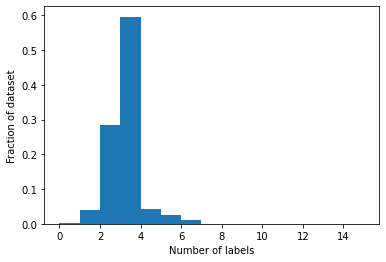

In [32]:
import matplotlib.pyplot as plt

%matplotlib inline


def plot_label_frequency(L):
    plt.hist((L != ABSTAIN).sum(axis=1), density=True, bins=range(L.shape[1]))
    plt.xlabel("Number of labels")
    plt.ylabel("Fraction of dataset")
    plt.show()


plot_label_frequency(L_train)

We see that over less than 1/10 of our `train` dataset data points have 0 or fewer labels from LFs. The labels we do have can be used to train a classifier over the comment text directly, allowing this final machine learning model to generalize beyond what our labeling functions labeling.

## 4. Train a generative noisy label model

Our goal is now to convert the labels from our LFs into a single noise-aware probabilistic (or confidence-weighted) label per data point. 

### Majority Label Voter

A simple baseline for doing this is to take the majority vote on a per-data point basis: if more LFs voted `MOTION` than `NOT_MOTION`, label it `MOTION` (and vice versa). We can test this with the `MajorityLabelVoter` baseline model.

In [47]:
majority_model = MajorityLabelVoter()
preds_train_majority_model = majority_model.predict(L=L_train)

### Probabilistic Label Model

In [48]:
label_model = LabelModel(cardinality=2, device='cpu', verbose=True)
label_model.fit(L_train=L_train, n_epochs=500, log_freq=100)

INFO:root:Computing O...
INFO:root:Estimating \mu...
  0%|          | 0/500 [00:00<?, ?epoch/s]INFO:root:[0 epochs]: TRAIN:[loss=0.487]
INFO:root:[100 epochs]: TRAIN:[loss=0.012]
INFO:root:[200 epochs]: TRAIN:[loss=0.012]
 46%|████▌     | 231/500 [00:00<00:00, 2302.79epoch/s]INFO:root:[300 epochs]: TRAIN:[loss=0.012]
INFO:root:[400 epochs]: TRAIN:[loss=0.012]
100%|██████████| 500/500 [00:00<00:00, 2478.74epoch/s]
INFO:root:Finished Training


In [35]:
preds_train_label_model = label_model.predict(L=L_train)

### Evaluating these models on the datasets

**Train accuracy**

In [49]:
majority_acc = majority_model.score(L=L_train, Y=df_train.motion, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")

label_model_acc = label_model.score(L=L_train, Y=df_train.motion, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

Majority Vote Accuracy:   98.0%
Label Model Accuracy:     94.4%


**Val accuracy**

In [50]:
majority_acc = majority_model.score(L=L_val, Y=df_val.motion, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")

label_model_acc = label_model.score(L=L_val, Y=df_val.motion, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

Majority Vote Accuracy:   98.0%
Label Model Accuracy:     94.7%


**Test accuracy**

In [51]:
majority_acc = majority_model.score(L=L_test, Y=df_test.motion, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")

label_model_acc = label_model.score(L=L_test, Y=df_test.motion, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

Majority Vote Accuracy:   97.7%
Label Model Accuracy:     93.6%


We can also analyze the labeling functions by looking at the distribution of the confidence scores for the model's predictions.

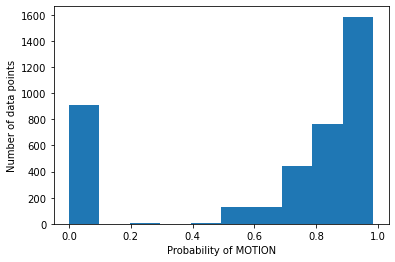

In [39]:
def plot_probabilities_histogram(Y):
    plt.hist(Y, bins=10)
    plt.xlabel("Probability of MOTION")
    plt.ylabel("Number of data points")
    plt.show()


probs_train = label_model.predict_proba(L=L_train)
plot_probabilities_histogram(probs_train[:, MOTION])

## 5. Prepare the training set for the discriminative model

The following code returns a dataframe with no samples with label: `ABSTAIN`.

In [40]:
from snorkel.labeling import filter_unlabeled_dataframe

df_train_filtered, probs_train_filtered = filter_unlabeled_dataframe(
    X=df_train, y=probs_train, L=L_train
)

In [42]:
df_train_filtered['motion'].value_counts()

1    3147
0    814 
Name: motion, dtype: int64

**We see that our dataset is unbalanced.** And this is a pretty likely scenario in practice.

**To do:** In the future, we can use undersampling or data augmentation.

We can use a library called [imbalanced-learn](https://imbalanced-learn.org/stable/) to perform random undersampling of the dataset.

```python
from imblearn.under_sampling import RandomUnderSampler

# Perform random under-sampling
sampler = RandomUnderSampler(random_state = 98052)
X_train_rus, Y_train_rus = sampler.fit_resample(X_train, y_train)
X_test_rus, Y_test_rus = sampler.fit_resample(X_test, y_test)
```

We can also use a library called [nlpaug](https://github.com/makcedward/nlpaug) to perform basic data augmentation of textual data. 

## 6. Train the discriminative model - in this case a text classifier

### Using noisy, hard labels

We can train a classifier with the labels as `MOTION` and `NOT MOTION`.

We use `probs_to_preds` to convert probabilistic labels to hard labels.

In [54]:
preds_train_filtered = probs_to_preds(probs=probs_train_filtered)

#### Baseline Approach 1: CountVectorizer and LogisticRegression

We use `sklearn CountVectorizer` to perform feature extraction on labeled data.

The following code:
- Gets training and test set. 
- Provides data in proper format for sklearn `CountVectorizer`

In [55]:
train_data = df_train_filtered.text.to_list()
test_data = df_test.text.to_list()

vectorizer = CountVectorizer(ngram_range=(1, 5))
X_train = vectorizer.fit_transform(train_data)
X_test = vectorizer.transform(test_data)

We use a LogisticRegression model from sklearn

In [74]:
sklearn_model = LogisticRegression(C=1e3, solver="liblinear")
sklearn_model.fit(X=X_train, y=preds_train_filtered)

LogisticRegression(C=1000.0, solver='liblinear')

In [75]:
print(f"Train Accuracy: {sklearn_model.score(X=X_train, y=df_train_filtered.motion) * 100:.1f}%")
print(f"Test Accuracy: {sklearn_model.score(X=X_test, y=df_test.motion) * 100:.1f}%")

Train Accuracy: 93.5%
Test Accuracy: 94.3%


Let's look at a classification report on the training set.

In [76]:
y_true_train = np.array(df_train_filtered.motion)
y_pred_train = sklearn_model.predict(X_train)

target_names = ['NOT MOTION', 'MOTION']
print(classification_report(y_true_train, y_pred_train, target_names=target_names))

              precision    recall  f1-score   support

  NOT MOTION       0.77      0.98      0.86       814
      MOTION       0.99      0.92      0.96      3146

    accuracy                           0.93      3960
   macro avg       0.88      0.95      0.91      3960
weighted avg       0.95      0.93      0.94      3960



Let's look at a classification report on the test set.

In [77]:
y_true_test = np.array(df_test.motion)
y_pred_test = sklearn_model.predict(X_test)
target_names = ['NOT MOTION', 'MOTION']
print(classification_report(y_true_test, y_pred_test, target_names=target_names))

              precision    recall  f1-score   support

  NOT MOTION       0.80      0.96      0.87       271
      MOTION       0.99      0.94      0.96      1051

    accuracy                           0.94      1322
   macro avg       0.89      0.95      0.92      1322
weighted avg       0.95      0.94      0.94      1322



#### Baseline Approach 2: TfidfVectorizer and LogisticRegression

We use `sklearn TfidfVectorizer` to perform feature extraction on labeled data.

The following code:
- Gets training and test set. 
- Provides data in proper format for sklearn `TfidfVectorizer`

In [56]:
train_data_tf = df_train_filtered.text.to_list()
test_data_tf = df_test.text.to_list()

vectorizer_tfidf = TfidfVectorizer(ngram_range=(1, 5))
X_train_tf = vectorizer_tfidf.fit_transform(train_data)
X_test_tf = vectorizer_tfidf.transform(test_data)

We use a LogisticRegression model from sklearn

In [80]:
sklearn_model_tf = LogisticRegression(C=1e3, solver="liblinear")
sklearn_model_tf.fit(X=X_train_tf, y=preds_train_filtered)

LogisticRegression(C=1000.0, solver='liblinear')

In [81]:
print(f"Train Accuracy: {sklearn_model_tf.score(X=X_train_tf, y=df_train_filtered.motion) * 100:.1f}%")
print(f"Test Accuracy: {sklearn_model_tf.score(X=X_test_tf, y=df_test.motion) * 100:.1f}%")

Train Accuracy: 93.5%
Test Accuracy: 93.9%


Let's look at a classification report on the training set.

In [82]:
y_true_train = np.array(df_train_filtered.motion)
y_pred_train = sklearn_model_tf.predict(X_train_tf)

target_names = ['NOT MOTION', 'MOTION']
print(classification_report(y_true_train, y_pred_train, target_names=target_names))

              precision    recall  f1-score   support

  NOT MOTION       0.77      0.98      0.86       814
      MOTION       0.99      0.92      0.96      3146

    accuracy                           0.93      3960
   macro avg       0.88      0.95      0.91      3960
weighted avg       0.95      0.93      0.94      3960



Let's look at a classification report on the test set.

In [83]:
y_true_test = np.array(df_test.motion)
y_pred_test = sklearn_model_tf.predict(X_test_tf)
target_names = ['NOT MOTION', 'MOTION']
print(classification_report(y_true_test, y_pred_test, target_names=target_names))

              precision    recall  f1-score   support

  NOT MOTION       0.79      0.96      0.86       271
      MOTION       0.99      0.93      0.96      1051

    accuracy                           0.94      1322
   macro avg       0.89      0.95      0.91      1322
weighted avg       0.95      0.94      0.94      1322



### Using probabilistic, noise aware labels.

We need to run a training with a model that is trained with the label probabilities as the training objective.
One way to do this in Huggingface is to finetune a language model for text classification with `logitloss`.
There is probably a way to do this with the simple sklearn algorithms. I need to look into it.

## Future Work:

1. Look at the labeling function creation. The Heuristic based LFs are effective but their technical barrier is too high. Use the `DataPoint` class to create a basis from which we can more easily define equivalent labeling functions, where the user input is less technical.
2. Expand this to multiclass classification as planned. To achieve this with more accessible labeling functions, we need to work on 1.
  - consider: evolving classes
3. Try training a model on probabilistic, noise aware labels.
4. Experimenting with class imbalance solutions.
5. Going over the data labeling procedure.
 - How do we break down the data exploration/labeling steps the user might perform? For now it's just sampling n samples or sampling n samples with a given label. A user may want to look at samples for which the model and labeling functions are wrong or uncertain.
6. Going over the labeling function creation procedure.
 - How do we guide the user to edit, remove, add labeling functions? Can we define a simple algorithm by looking at the LFAnalysis statistics?
7. How do we support data exploration?